In [1]:
%matplotlib inline
import cv2


# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm, tqdm_notebook

# import utilities to keep workspaces alive during model training
# from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:

## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from model import Net

net = Net()
print(net)

C:\Users\Geetha reddy\Downloads\model.py:58: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  I.xavier_uniform(self.fc1.weight.data)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

C:\Users\Geetha reddy\Downloads\model.py:59: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  I.xavier_uniform(self.fc2.weight.data)
C:\Users\Geetha reddy\Downloads\model.py:60: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  I.xavier_uniform(self.fc3.weight.data)


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor

## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [6]:
batch_size = 64

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [7]:

# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

In [8]:

# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [9]:

# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [10]:

# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

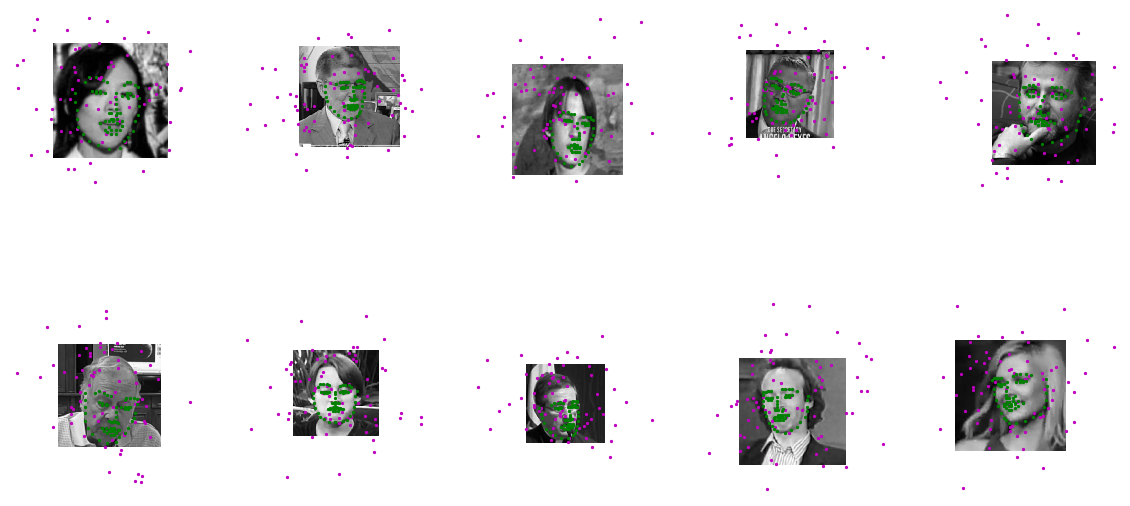

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    
    
    plt.figure(figsize=(20,10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size//5, 5, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [14]:
from tqdm import tqdm, tqdm_notebook

def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in tqdm_notebook(range(n_epochs), desc="training"):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        batch_i = 0
        for data in tqdm_notebook(train_loader, desc="epoch {}".format(epoch)):
            
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()

            if batch_i % 10 == 9:    # print every 10 batches
                tqdm.write('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(
                    epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
                
            batch_i+=1

    print('Finished Training')

In [15]:
# train your network
n_epochs = 9 # start small, and increase when you've decided on your 
              # model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
# with active_session():
#     train_net(n_epochs)

train_net(n_epochs)

C:\Users\Geetha reddy\anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


C:\Users\Geetha reddy\anaconda3\lib\site-packages\ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch: 1, Batch: 10, Avg. Loss: 0.9014965653419494
Epoch: 1, Batch: 20, Avg. Loss: 0.6711016476154328
Epoch: 1, Batch: 30, Avg. Loss: 0.5554929316043854
Epoch: 1, Batch: 40, Avg. Loss: 0.5037889122962952
Epoch: 1, Batch: 50, Avg. Loss: 0.46154616177082064



Epoch: 2, Batch: 10, Avg. Loss: 0.4087059050798416
Epoch: 2, Batch: 20, Avg. Loss: 0.3752383887767792
Epoch: 2, Batch: 30, Avg. Loss: 0.34382459819316863
Epoch: 2, Batch: 40, Avg. Loss: 0.3244923412799835
Epoch: 2, Batch: 50, Avg. Loss: 0.301771280169487



Epoch: 3, Batch: 10, Avg. Loss: 0.30778650343418124
Epoch: 3, Batch: 20, Avg. Loss: 0.28422703593969345
Epoch: 3, Batch: 30, Avg. Loss: 0.26557773500680926
Epoch: 3, Batch: 40, Avg. Loss: 0.25686794966459275
Epoch: 3, Batch: 50, Avg. Loss: 0.23077693730592727



Epoch: 4, Batch: 10, Avg. Loss: 0.25103131532669065
Epoch: 4, Batch: 20, Avg. Loss: 0.20070048421621323
Epoch: 4, Batch: 30, Avg. Loss: 0.21029206365346909
Epoch: 4, Batch: 40, Avg. Loss: 0.18435481190681458
Epoch: 4, Batch: 50, Avg. Loss: 0.16848138272762297



Epoch: 5, Batch: 10, Avg. Loss: 0.16115632504224778
Epoch: 5, Batch: 20, Avg. Loss: 0.1541232042014599
Epoch: 5, Batch: 30, Avg. Loss: 0.15676706731319429
Epoch: 5, Batch: 40, Avg. Loss: 0.1489860251545906
Epoch: 5, Batch: 50, Avg. Loss: 0.1342781513929367



Epoch: 6, Batch: 10, Avg. Loss: 0.16140770465135573
Epoch: 6, Batch: 20, Avg. Loss: 0.13976843133568764
Epoch: 6, Batch: 30, Avg. Loss: 0.13425346910953523
Epoch: 6, Batch: 40, Avg. Loss: 0.11859703809022903
Epoch: 6, Batch: 50, Avg. Loss: 0.1416766934096813



Epoch: 7, Batch: 10, Avg. Loss: 0.1331021524965763
Epoch: 7, Batch: 20, Avg. Loss: 0.10928546115756035
Epoch: 7, Batch: 30, Avg. Loss: 0.11130813658237457
Epoch: 7, Batch: 40, Avg. Loss: 0.11665303632616997
Epoch: 7, Batch: 50, Avg. Loss: 0.11545246094465256



Epoch: 8, Batch: 10, Avg. Loss: 0.12945166304707528
Epoch: 8, Batch: 20, Avg. Loss: 0.1071335181593895
Epoch: 8, Batch: 30, Avg. Loss: 0.1016930378973484
Epoch: 8, Batch: 40, Avg. Loss: 0.09524606987833976
Epoch: 8, Batch: 50, Avg. Loss: 0.10445654839277267



Epoch: 9, Batch: 10, Avg. Loss: 0.09911158680915833
Epoch: 9, Batch: 20, Avg. Loss: 0.0975344493985176
Epoch: 9, Batch: 30, Avg. Loss: 0.09851493462920188
Epoch: 9, Batch: 40, Avg. Loss: 0.08790852688252926
Epoch: 9, Batch: 50, Avg. Loss: 0.09028442651033401


Finished Training


In [16]:
model_dir = 'saved_models/'
model_name = 'keypoints_model.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

In [17]:
losses = [0.9014965653419494,
 0.6711016476154328,
0.5554929316043854,
 0.5037889122962952,
 0.46154616177082064,
 0.4087059050798416,
 0.3752383887767792,
 0.34382459819316863,
0.3244923412799835,
 0.301771280169487,
0.30778650343418124,
 0.28422703593969345,
 0.26557773500680926,
 0.25686794966459275,
 0.23077693730592727,
 0.25103131532669065,
0.20070048421621323,
 0.21029206365346909,
0.18435481190681458,
 0.16848138272762297,
 0.16115632504224778,
 0.1541232042014599,
0.15676706731319429,
 0.1489860251545906,
 0.1342781513929367,
0.16140770465135573,
 0.13976843133568764,
 0.13425346910953523,
 0.11859703809022903,
 0.1416766934096813,
 0.1331021524965763,
 0.10928546115756035,
0.11130813658237457,
 0.11665303632616997,
0.11545246094465256,
 0.12945166304707528,
 0.1071335181593895,
 0.1016930378973484,
 0.09524606987833976,
 0.10445654839277267,
 0.09911158680915833,
 0.0975344493985176,
 0.09851493462920188,
 0.08790852688252926,
 0.09028442651033401]

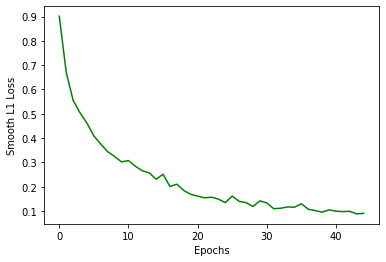

In [18]:
plt.xlabel("Epochs")
plt.ylabel("Smooth L1 Loss")
plt.plot(losses, "g-")

In [19]:
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


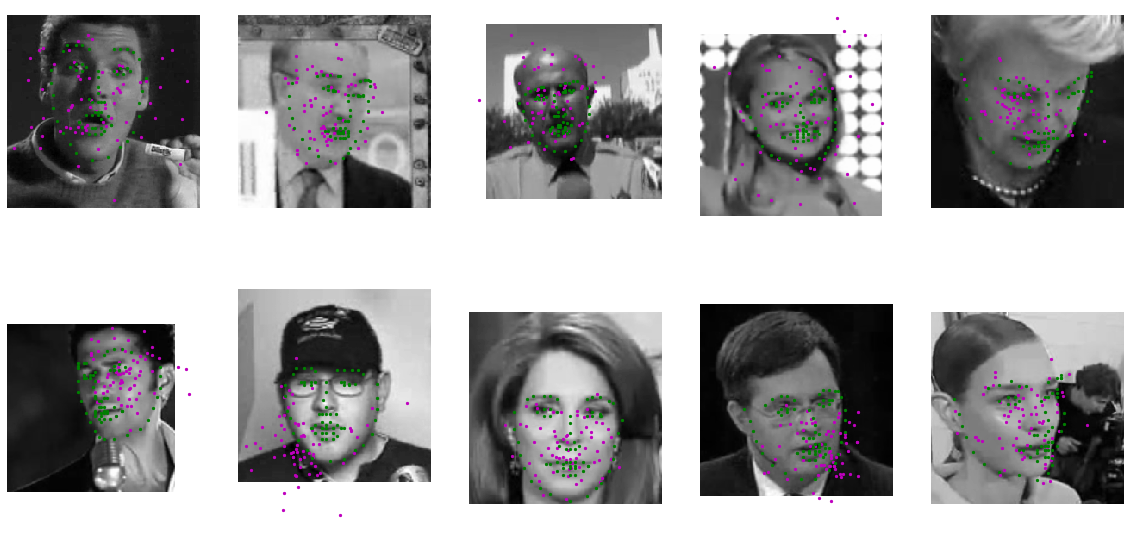

In [20]:
visualize_output(test_images, test_outputs, gt_pts)

[[ 0.05004281 -0.0686708   0.14314319 -0.13070223]
 [ 0.05111061 -0.21914847 -0.05201606 -0.02888573]
 [ 0.12513535 -0.11988088 -0.06109478 -0.15505433]
 [ 0.23047002 -0.04915434  0.02934257  0.17688194]]
(4, 4)


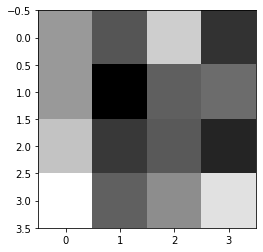

In [21]:
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

First convolutional layer


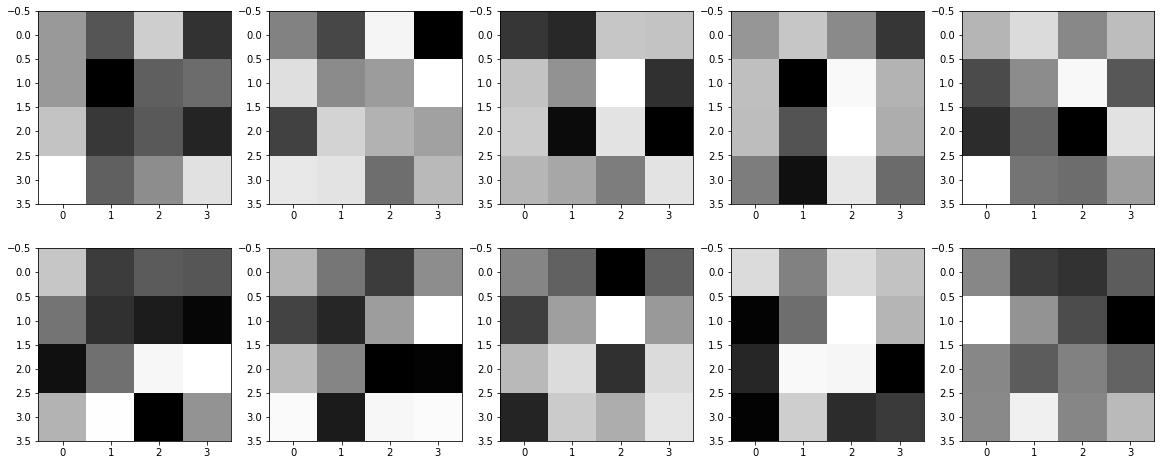

In [22]:
weights = net.conv1.weight.data
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

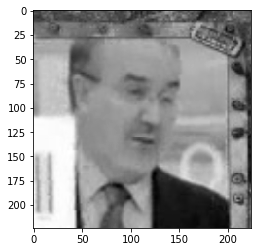

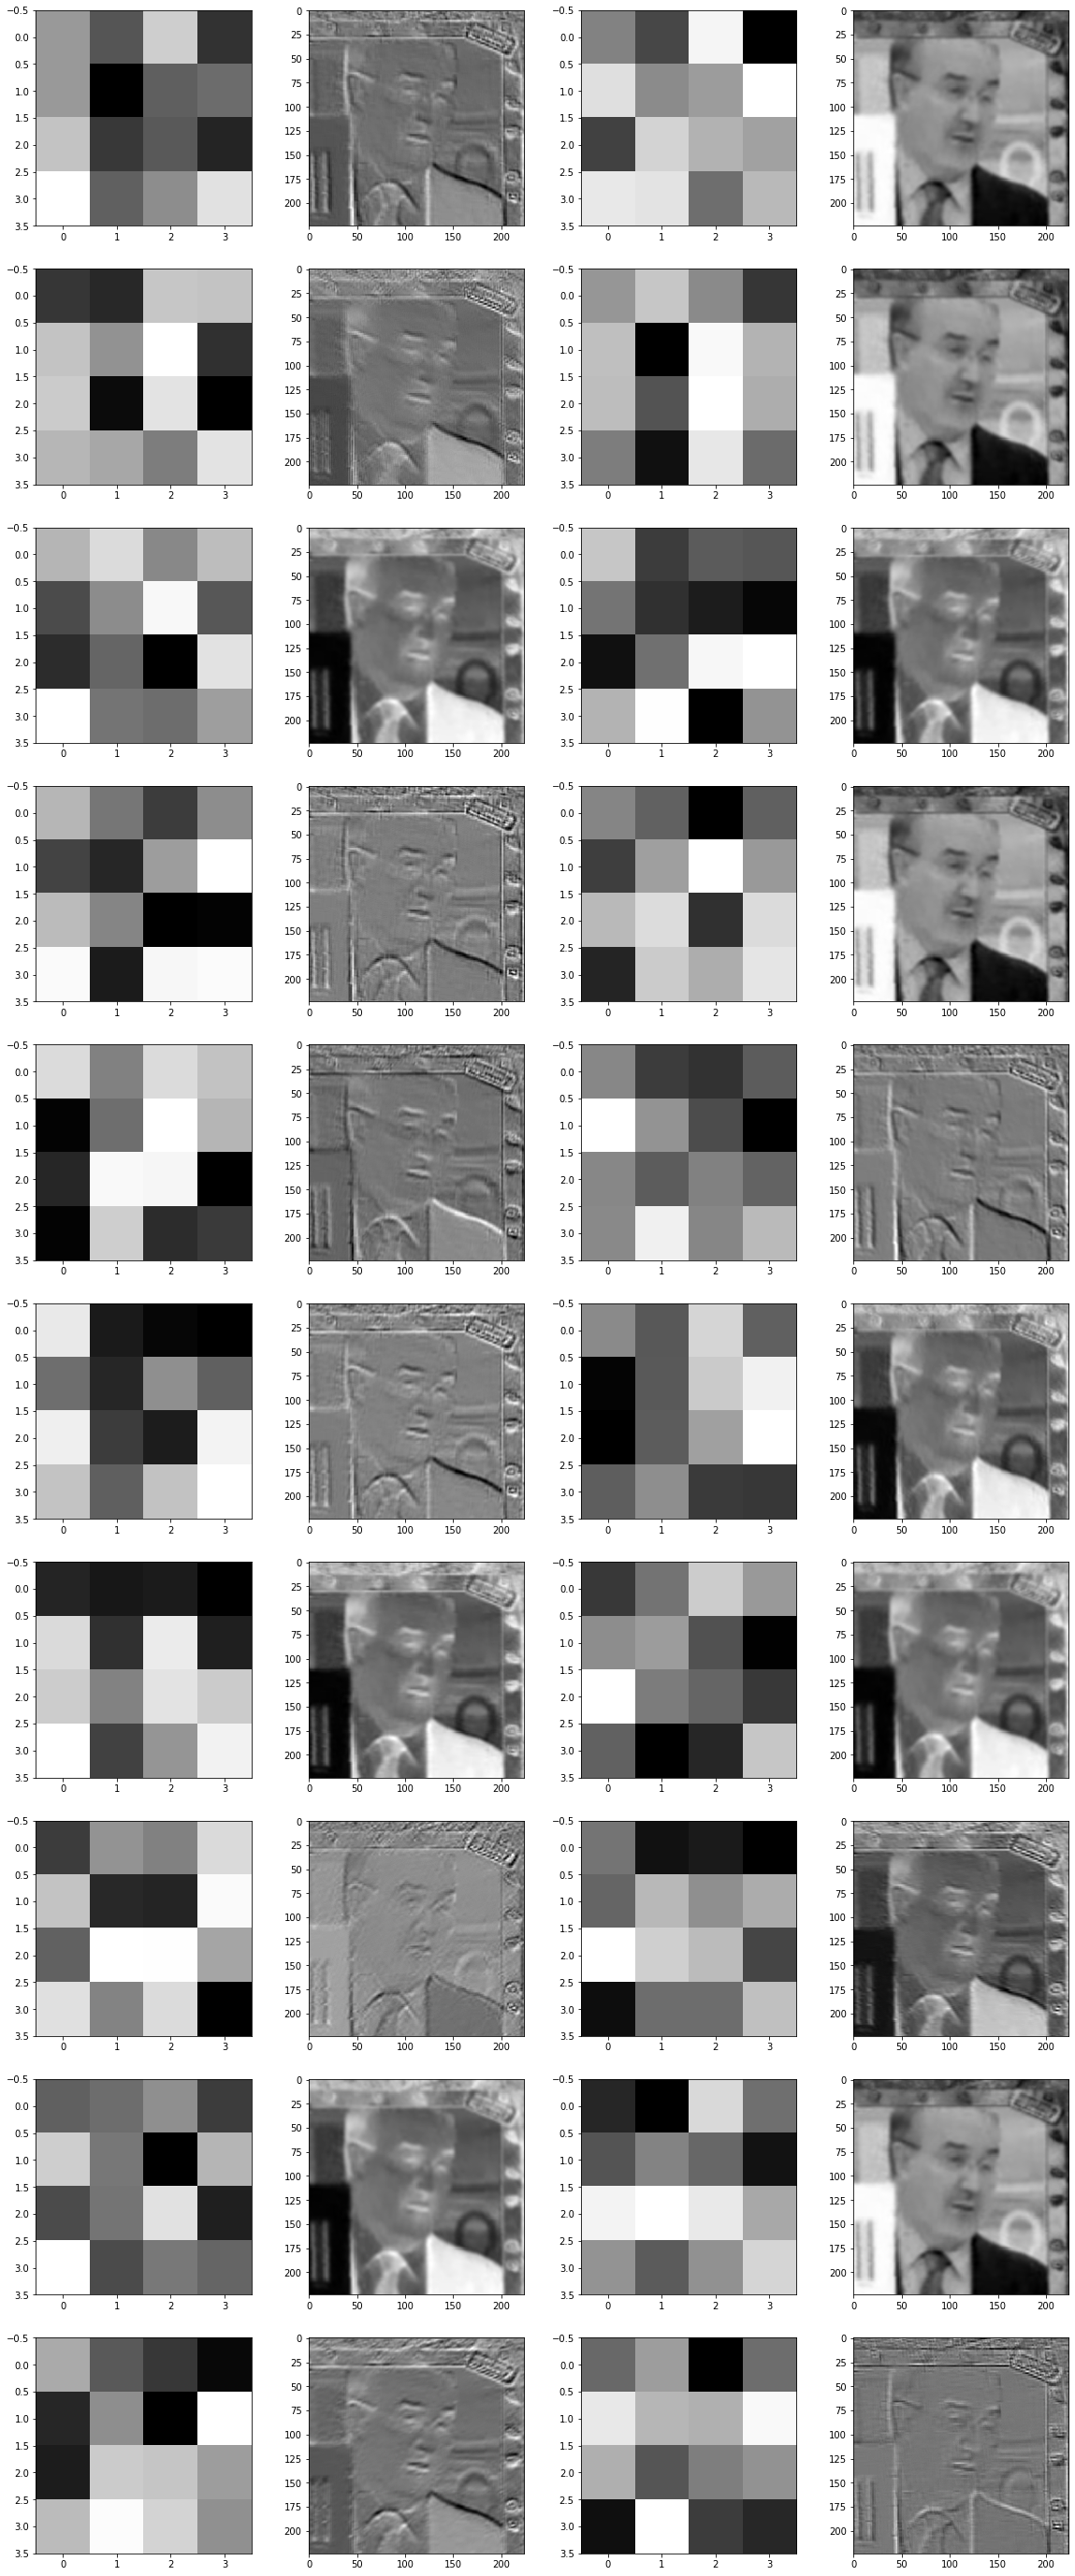

In [23]:
img = np.squeeze(test_images[1])
img = np.array(img)

plt.imshow(img, cmap='gray')
weights = net.conv1.weight.data
w = weights.numpy()

fig=plt.figure(figsize=(20, 50))
columns = 4
rows = 10
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()